In [1]:
!pip install d2l

     |████████████████████████████████| 82 kB 831 kB/s 
     |████████████████████████████████| 61 kB 10.2 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
     |████████████████████████████████| 11.6 MB 75.9 MB/s 
     |████████████████████████████████| 9.9 MB 70.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the 

One insight in this network
is that sometimes it can be advantageous to employ a combination of variously-sized kernels.

**Inception Blocks**  
The basic convolutional block in GoogLeNet is called an Inception block.  
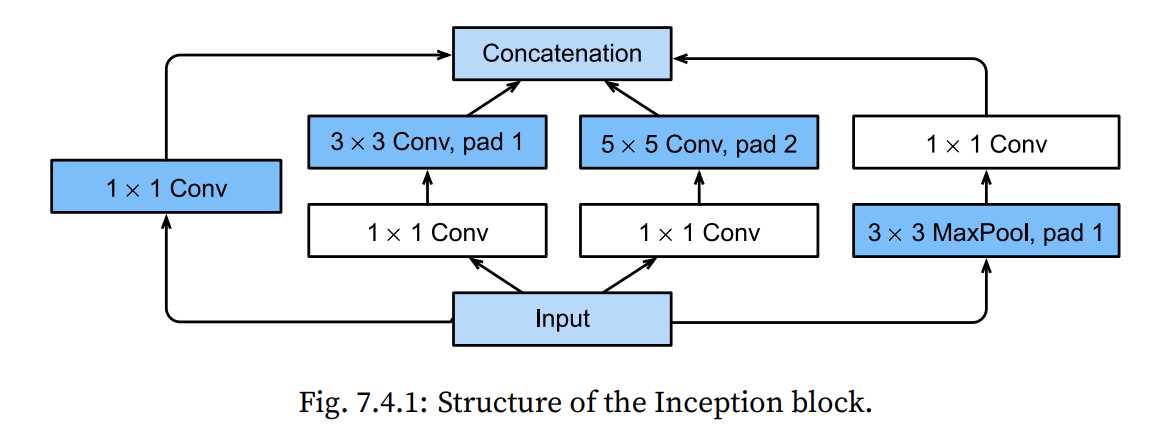  
In this Figure, using convolutional layers with window sizes of $1 \times 1$, $3 \times 3$ and $5 \times 5$, a $3 \times 3$ maximum pooling layer (all blue blocks) to extract information from different spatial sizes; using (all white blocks) $1 \times 1$ convolutional layer to change the number of channels.

**Note**: Using padding to make the input and output be the same height and width.

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [4]:
# implement the inception block class
class Inception(nn.Module):
  def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
    super(Inception, self).__init__(**kwargs)
    # Path 1 is a 1 X 1 CONV layer
    self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
    # Path 2 is a 1 X 1 CONV layer followed by a 3 X 3 CONV layer
    self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
    self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
    # Path 3 is a 1 X 1 CONV layer followed by a 5 X 5 CONV layer
    self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
    self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
    # Path 4 is a 3 X 3 MaxPooling layer followed by a 1 X 1 CONV layer
    self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
    
  def forward(self, x):
    p1 = F.relu(self.p1_1(x))
    p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
    p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
    p4 = F.relu(self.p4_2(self.p4_1(x)))
    # concatenate the outputs on the channel dimension
    return torch.cat((p1, p2, p3, p4), dim=1)
    

**GoogLeNet Model**  
GoogLeNet uses a stack of a total of 9 inception blocks and global average pooling to generate its estimates. Maximum pooling between inception blocks reduces the
dimensionality. The first module is similar to AlexNet and LeNet. The stack of blocks is inherited
from VGG and the global average pooling avoids a stack of fully-connected layers at the end.
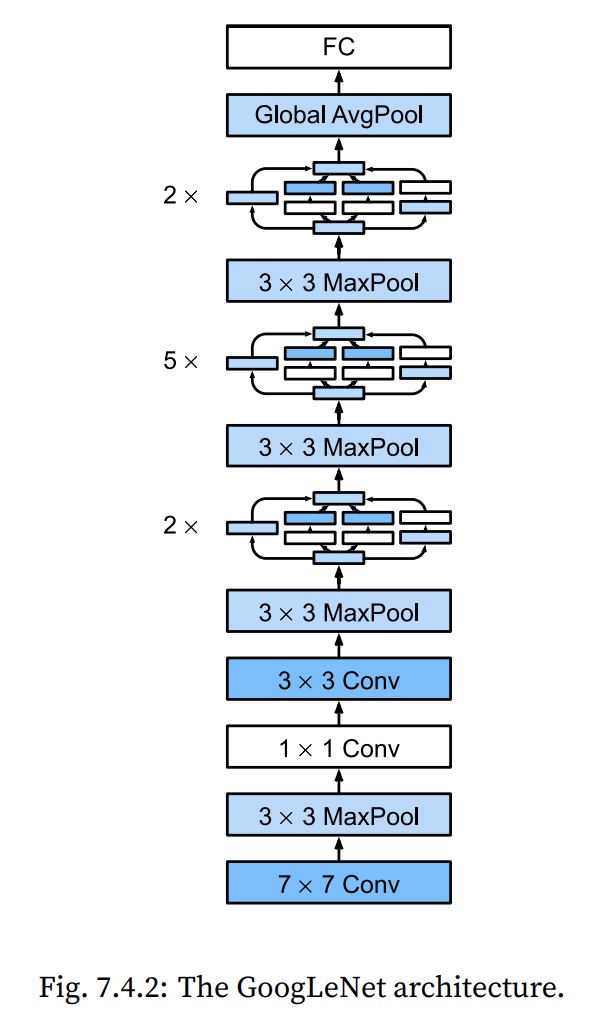

In [5]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                  nn.ReLU(),
                  nn.Conv2d(64, 192, kernel_size=3, padding=1),
                  nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [7]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                  Inception(256, 128, (128, 192), (32, 96), 64),
                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [8]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                  Inception(512, 160, (112, 224), (24, 64), 64),
                  Inception(512, 128, (128, 256), (24, 64), 64),
                  Inception(512, 112, (144, 288), (32, 64), 64),
                  Inception(528, 256, (160, 320), (32, 128), 128),
                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [9]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                  Inception(832, 384, (192, 384), (48, 128), 128),
                  nn.AdaptiveAvgPool2d((1,1)),
                  nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [10]:
X = torch.rand((1, 1, 224, 224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output layer:\t', X.shape)

Sequential output layer:	 torch.Size([1, 64, 56, 56])
Sequential output layer:	 torch.Size([1, 192, 28, 28])
Sequential output layer:	 torch.Size([1, 480, 14, 14])
Sequential output layer:	 torch.Size([1, 832, 7, 7])
Sequential output layer:	 torch.Size([1, 1024])
Linear output layer:	 torch.Size([1, 10])


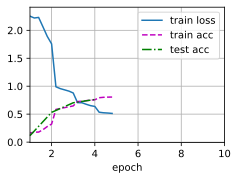

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**Summary**:
1. The Inception block is equivalent to a subnetwork with four paths. It extracts information
in parallel through convolutional layers of different window shapes and maximum pooling
layers. **1 × 1 convolutions reduce channel dimensionality on a per-pixel level. Maximum
pooling reduces the resolution.**
2. GoogLeNet connects multiple well-designed Inception blocks with other layers in series.
The ratio of the number of channels assigned in the Inception block is obtained through **a
large number of experiments** on the ImageNet dataset.
3. GoogLeNet, as well as its succeeding versions, was one of the most efficient models on ImageNet, providing similar test accuracy with lower computational complexity.